In [3]:
# Note the sys.path is hardcoded to my computer

# Zachary Katz
# zachary_katz@mines.edu
# October 2024

"""
Make input files for Figure2.sh

v1.0 01 November 2024
    Use example events from 2013
"""

# Imports
import os
import sys
import logging
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import scipy

sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog",
)
import Catalog

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
#year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]
year_arr = [['2013']]

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event
hr_off = 0 # Offset for hours on either side of threshold to save [hours]

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 


# fmt: on
########################## User Defined Variables ##############################
################################################################################


def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [4]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)
    picks.lls_detection(window, slide)
    sorted_list = picks.on_off_list()
    no_data = picks.no_data_csv(min_stas, sorted_list)

    merged_df = picks.merge()
    merged = Catalog.Events(merged_df)
    threshold = merged.pick_events(sorted_list, active_stas=min_stas, hr_off=hr_off)

    catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)

2024-12-05 10:03:20 __main__ INFO: Creating Dataframe for la01
2024-12-05 10:03:45 __main__ INFO: Interpolating la01
2024-12-05 10:03:47 Catalog INFO: 2013-02-02 14:52:00 2013-02-02 14:52:45 0 days 00:00:45
2024-12-05 10:03:58 __main__ INFO: Creating Dataframe for la02
2024-12-05 10:04:18 __main__ INFO: Interpolating la02
2024-12-05 10:04:20 Catalog INFO: 2013-01-26 04:42:00 2013-01-26 04:42:45 0 days 00:00:45
2024-12-05 10:04:20 Catalog INFO: 2013-01-26 05:06:15 2013-01-26 05:08:00 0 days 00:01:45
2024-12-05 10:04:20 Catalog INFO: 2013-01-26 05:08:45 2013-01-26 05:09:30 0 days 00:00:45
2024-12-05 10:04:21 Catalog INFO: 2013-02-02 07:59:45 2013-02-02 08:00:30 0 days 00:00:45
2024-12-05 10:04:23 Catalog INFO: 2013-02-26 17:16:00 2013-02-26 17:18:00 0 days 00:02:00
2024-12-05 10:04:25 Catalog INFO: 2013-03-28 17:17:30 2013-03-28 17:19:30 0 days 00:02:00
2024-12-05 10:04:27 Catalog INFO: 2013-04-27 17:18:45 2013-04-27 17:20:45 0 days 00:02:00
2024-12-05 10:04:29 Catalog INFO: 2013-05-27 1

TypeError: strptime() argument 1 must be str, not Timestamp

In [ ]:
# Find indices for fig2
indices = []
for time in sorted_list["times"]:
    index = merged.merged.index[merged.merged["time"] == time][0]
    indices.append(index)

x_cols = [col for col in merged.merged.columns if col.endswith("x")]
st_time = datetime.datetime.strptime("2013-01-24:06:00:00", "%Y-%m-%d:%H:%M:%S")
end_time = datetime.datetime.strptime("2013-01-29:00:00:00", "%Y-%m-%d:%H:%M:%S")
start = min(merged.merged["time"], key=lambda x: abs(x - st_time))
end = min(merged.merged["time"], key=lambda x: abs(x - end_time))
start = merged.merged.index[merged.merged["time"] == start][0]
end = merged.merged.index[merged.merged["time"] == end][0]

In [ ]:
# Save for GMT plotting
st_index = start
ed_index = end

df = merged.merged[st_index:ed_index]
df["Threshold"] = threshold[st_index:ed_index]
df.dropna(axis=1, how="all", inplace=True)

x_cols = [col for col in df if col.endswith("x")]
for x_col in x_cols:
    df[x_col] = (
        df[x_col] - np.mean(df[x_col]) - (df[x_col].iloc[0] - np.mean(df[x_col]))
    )
df.to_csv("LeastSquaresGMT.txt", sep="\t", index=False, na_rep="NaN")

/tmp/ipykernel_89814/4195664681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Threshold"] = threshold[st_index:ed_index]
/tmp/ipykernel_89814/4195664681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, how="all", inplace=True)
/tmp/ipykernel_89814/4195664681.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [ ]:
# Load events into dataframe
data = {"event": [], "trace_time": []}
directory = f"../Events_{min_stas}stas/"
# folders = ['2007_2009Events','2010_2011Events','2012_2013Events','2014_2015Events','2016_2019Events']
folders = [f"2013_2013Events_{min_stas}stas"]
for folder in folders:
    for file in os.listdir(f"{directory}{folder}"):
        df = pd.read_csv(f"{directory}{folder}/{file}", sep="\t")
        data["event"].append(df)
        data["trace_time"].append(file[:-4])


def plot_event(j, event_to_plot):
    x_cols = [col for col in event_to_plot if col.endswith("x")]
    times = [
        datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        for time in event_to_plot["time"]
    ]
    fig, ax1 = plt.subplots()
    first = True
    for i, x_col in enumerate(x_cols):
        demeaned_to_0 = (event_to_plot[x_col] - np.mean(event_to_plot[x_col])) - (
            event_to_plot[x_col][event_to_plot.index[0]] - np.mean(event_to_plot[x_col])
        )
        if not np.isnan(event_to_plot[x_col][event_to_plot.index[0]]):
            if first:
                ax2_dummy = demeaned_to_0
                first = False
            ax1.plot(times, demeaned_to_0, label=x_col[:-1], color="gray")
    ax1.set_ylabel("X Displacement [meters]")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.legend()
    ax3 = ax1.twinx()
    ax3.plot(times, data["grad2"][j])
    ax3.vlines(data["ev_time"][j], -1e-6, 1e-6)

    # Setup dates using second axis
    ax2 = ax1.twiny()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
    fig.subplots_adjust(bottom=0.10)
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 20))
    ax2.set_xlabel("DateTime")

    # Need to plot something on ax2 to getthe correct dates
    ax2.plot(times, ax2_dummy, color="gray")
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

In [ ]:
def plot_grads(event_to_plot, grad1s, grad2s):
    import matplotlib.colors as mcolors

    original_colors = list(mcolors.CSS4_COLORS.keys())[:30]

    x_cols = [col for col in event_to_plot if col.endswith("x")]
    times = [
        datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        for time in event_to_plot["time"]
    ]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    # Create pairs of light and adark colors for trace and 2nd deriv
    for i, (x_col, grad2) in enumerate(zip(x_cols, grad2s)):
        if x_col in ["gz01x", "la09x"]:
            demeaned_to_0 = (event_to_plot[x_col] - np.mean(event_to_plot[x_col])) - (
                event_to_plot[x_col][event_to_plot.index[0]]
                - np.mean(event_to_plot[x_col])
            )
            if not np.isnan(event_to_plot[x_col][event_to_plot.index[0]]):
                ax1.plot(
                    times, demeaned_to_0, label=x_col[:-1], color=original_colors[i]
                )

            ax2.plot(times, grad2, color=original_colors[i])

    ax1.set_ylabel("X Displacement [meters]")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.legend()
    ax2.set_ylabel("2nd Derivative")

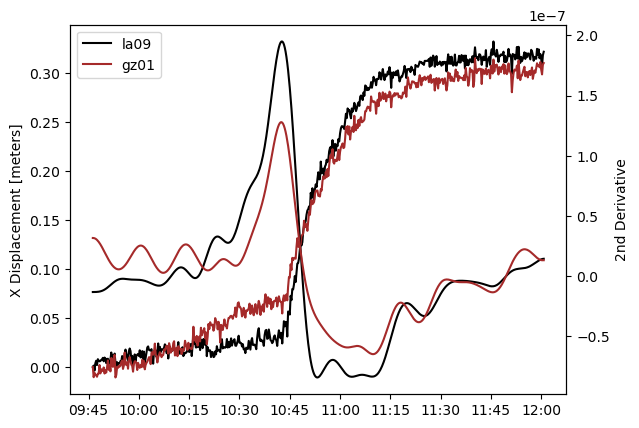

In [ ]:
def derivative(time, x_col, order, crit, spacing):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of
    order - order of butterworth filter
    crit - critical value of butterworth filter
    spacing - spacing of gradient
    Returns
    grad2 - Second derivative [list]
    """
    y_data = x_col - np.mean(x_col)

    # 1st derivative
    b, a = scipy.signal.butter(order, crit)
    filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
    grad = np.gradient(filtered, spacing)
    return grad


def derivative2(time, grad, order, crit, spacing):
    # 2nd derivative
    b, a = scipy.signal.butter(order, crit)
    grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
    grad2 = np.gradient(grad_filtered, spacing)

    return grad2


# Compute average second derivatives of all traces for each event
avg_grad2s = []
avg_grad1s = []
for event in data["event"][104:105]:
    x_cols = [col for col in event if col.endswith("x")]
    grad2s = []
    grad1s = []
    # print(len(event['time']),event['time'][0])
    for x_col in x_cols:
        grad = derivative(event["time"], event[x_col], 1, 0.01, 15)
        grad2 = derivative(event["time"], grad, 4, 0.05, 15)
        grad2s.append(grad2)
        grad1s.append(grad)
    avg_grad2s.append(np.nanmean(grad2s, axis=0))
    avg_grad1s.append(np.nanmean(grad1s, axis=0))

    plot_grads(event, grad1s, grad2s)
data["grad2"] = avg_grad2s
data["grad1"] = avg_grad1s

# Compute index of max
max_index = [np.argmax(i) for i in data["grad2"]]
data["grad2maxIndex"] = max_index

# Calculate event start times based on 2nd derivative
data["ev_time"] = [
    data["event"][i]["time"][data["grad2maxIndex"][i]]
    for i in range(len(data["event"][104:105]))
]

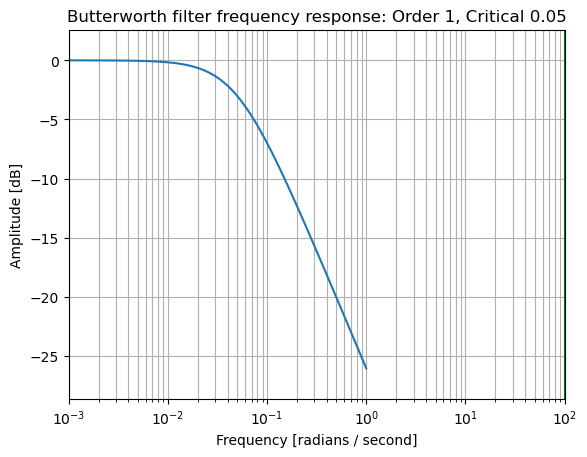

In [ ]:
import scipy.signal as signal

order = 1
crit = 0.05
b, a = signal.butter(order, crit, "low", analog=True)

w, h = signal.freqs(b, a)

plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title(f"Butterworth filter frequency response: Order {order}, Critical {crit}")

plt.xlabel("Frequency [radians / second]")

plt.ylabel("Amplitude [dB]")

plt.margins(0, 0.1)

plt.grid(which="both", axis="both")

plt.axvline(100, color="green")  # cutoff frequency

plt.show()

2013-03-12 10:42:30
104
2013-04-13 04:46:30
152
[ 1.49930106e-06  1.49126773e-06  1.46752115e-06  1.42880367e-06
  1.37606228e-06  1.31055953e-06  1.23382354e-06  1.14759012e-06
  1.05374073e-06  9.54239504e-07  8.51072652e-07  7.46192440e-07
  6.41467543e-07  5.38640712e-07  4.39294289e-07  3.44823774e-07
  2.56419173e-07  1.75053373e-07  1.01476575e-07  3.62159668e-08
 -2.04197499e-08 -6.83312414e-08 -1.07615095e-07 -1.38546393e-07
 -1.61557608e-07 -1.77214077e-07 -1.86186346e-07 -1.89219918e-07
 -1.87103612e-07 -1.80638672e-07 -1.70611219e-07 -1.57769997e-07
 -1.42810006e-07 -1.26361466e-07 -1.08983140e-07 -9.11591207e-08
 -7.32985394e-08 -5.57380808e-08 -3.87473529e-08 -2.25367911e-08
 -7.26706533e-09  6.94134367e-09  1.99993453e-08  3.18415895e-08
  4.24202534e-08  5.17009149e-08  5.96612955e-08  6.62930174e-08
  7.16053441e-08  7.56289652e-08  7.84179125e-08  8.00485995e-08
  8.06160650e-08  8.02281361e-08  7.89983541e-08  7.70385009e-08
  7.44516317e-08  7.13265556e-08  6.773454

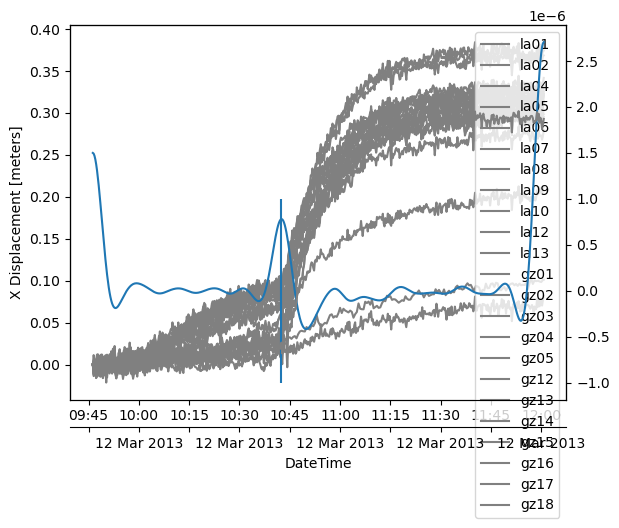

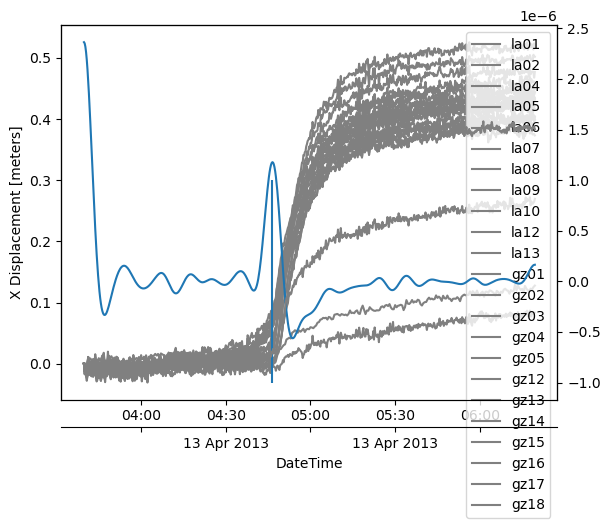

In [ ]:
# Plot event, 2nd derivative, and max

# Get times of two showcase events for plotting
event1 = datetime.datetime.strptime("2013-03-12 09:00:00", "%Y-%m-%d %H:%M:%S")
event2 = datetime.datetime.strptime("2013-04-13 03:00:00", "%Y-%m-%d %H:%M:%S")
evts = [event1, event2]
df = pd.read_csv(
    f"../EventStartTime_{min_stas}stas/2013EventStartTime_{min_stas}stas.txt", sep="\t"
)
ev_times = df["EventStartTime"]
data["ev_time"] = [
    datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in ev_times
]

ev_indices = np.zeros(len(evts), dtype=int)
# Find index of showcase events
for i, event in enumerate(evts):
    actual_time = min(data["ev_time"], key=lambda d: abs(d - event))
    print(actual_time)
    print(data["ev_time"].index(actual_time))
    ev_indices[i] = data["ev_time"].index(actual_time)

TO_UM = 1e6
ev_to_plot = []
for a, i in enumerate(ev_indices):
    print(data["grad2"][i])
    data["event"][i]["grad2"] = data["grad2"][i] * TO_UM
    data["event"][i]["ev_time"] = data["ev_time"][i]
    ev_to_plot.append(data["event"][i])

for i, event in zip(ev_indices, ev_to_plot):
    plot_event(i, data["event"][i])

In [ ]:
# Save for GMT Plotting
for i, (event_index, event) in enumerate(zip(ev_indices, ev_to_plot)):
    time = event["time"].iloc[0][:10]
    os.mkdir(f"{i}_{time}")
    # Save x columns
    x_cols = [col for col in event if col.endswith("x")]
    for x_col in x_cols:
        nans = np.isnan(event[x_col]).any()
        if not nans:
            x_col_cap = x_col.upper()
            event[x_col_cap] = event[x_col] - event[x_col].iloc[0]
            event.to_csv(
                f"{i}_{time}/{x_col}.txt",
                columns=["time", x_col_cap],
                sep="\t",
                index=None,
            )
    # Save 2nd derivative and start time
    event.to_csv(
        f"{i}_{time}/grad2.txt",
        columns=["time", "grad2", "ev_time"],
        sep="\t",
        index=None,
    )

FileExistsError: [Errno 17] File exists: '1_2013-04-13'